#Montaje e Importación de Librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling, RandomContrast, RandomTranslation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

#El modelo

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://github.com/priya-dwivedi/Deep-Learning/tree/master/resnet_keras

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32

In [ ]:
df_train=pd.read_excel("train_20imgs_nobal.xlsx")
df_test=pd.read_excel("test0-7.xlsx")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 326 validated image filenames belonging to 3 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 81 validated image filenames belonging to 3 classes.


In [ ]:
data_augmentation = Sequential([  #package: experimental.preprocessing
  Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), #NN work better with small values
  RandomFlip('horizontal'),
  RandomRotation(0.2),
  RandomContrast(0.2),
  RandomTranslation(height_factor=0.2,width_factor=0.2),
  RandomZoom( height_factor = (-0.2,0.2),width_factor = (-0.2,0.2))
])

In [ ]:
model = models.Sequential()
model.add(data_augmentation)
conv_base = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) )
conv_base.trainable = False 
model.add(conv_base)
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES , activation= 'softmax')(x)
model = Model(inputs = conv_base.input, outputs = predictions)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________

In [ ]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.01) #0.001
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 200,workers=10, callbacks=[EarlyStopping(monitor='val_loss',patience=40,restore_best_weights=True),ReduceLROnPlateau(monitor='val_loss',factor = 0.1,patience=5,min_lr=0)], batch_size = BATCH_SIZE)

Epoch 1/200
23/23 [==============================] - 17s 408ms/step - loss: 2.5064 - accuracy: 0.6368 - val_loss: 9087127153010540544.0000 - val_accuracy: 0.6354
Epoch 2/200
23/23 [==============================] - 10s 359ms/step - loss: 0.8224 - accuracy: 0.8719 - val_loss: 1762674606080.0000 - val_accuracy: 0.6354
Epoch 3/200
23/23 [==============================] - 10s 361ms/step - loss: 1.0034 - accuracy: 0.9079 - val_loss: 55630999552.0000 - val_accuracy: 0.6354
Epoch 4/200
23/23 [==============================] - 11s 363ms/step - loss: 0.9400 - accuracy: 0.8612 - val_loss: 1179919.3750 - val_accuracy: 0.6354
Epoch 5/200
23/23 [==============================] - 10s 360ms/step - loss: 0.5988 - accuracy: 0.9065 - val_loss: 12326.0156 - val_accuracy: 0.6354
Epoch 6/200
23/23 [==============================] - 10s 363ms/step - loss: 1.2309 - accuracy: 0.6796 - val_loss: 72664624.0000 - val_accuracy: 0.6354
Epoch 7/200
23/23 [==============================] - 11s 368ms/step - loss: 1.0

In [ ]:
model.save('ResNet2_2.5%.h5')

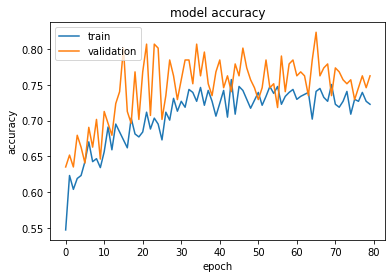

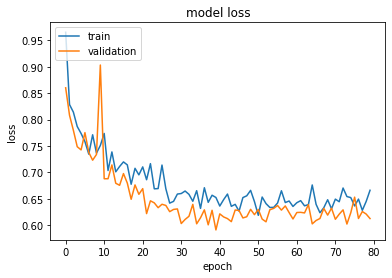

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)#Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [37]:
model = load_model('ResNet2_2.5%.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 43s 10ms/step
(4360, 3)


In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

Loss = [0.01285766 0.07938529 0.90775704]
Test Accuracy = [0.03561691 0.25418124 0.71020186]


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

In [ ]:
#Obtenemos el nombre de clase asignado a cada clase
preds_classes = [classes_dict[p] for p in preds]

In [ ]:
# A qué clase asigna cada imagen
preds_classes

In [39]:
#Evaluar cuantas predicciones hay de cada clase
pd.Series(preds_classes).value_counts()

PA    4234
L      126
dtype: int64

In [ ]:
import numpy as np
#Obtenemos el nombre de clase de la etiqueta verdadera (groun-truths)
gts = np.array([classes_dict[p] for p in test_batches.classes])

In [38]:
#Evaluamos métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(gts,preds_classes))

               precision    recall  f1-score   support

AP_horizontal       0.00      0.00      0.00       217
            L       0.85      0.07      0.14      1427
           PA       0.64      1.00      0.78      2716

     accuracy                           0.65      4360
    macro avg       0.50      0.36      0.31      4360
 weighted avg       0.68      0.65      0.53      4360



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
def plot_confusion_matrix(cm, classes,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize=20)
    plt.xlabel('Predicción del modelo', fontsize=20)
    plt.show()

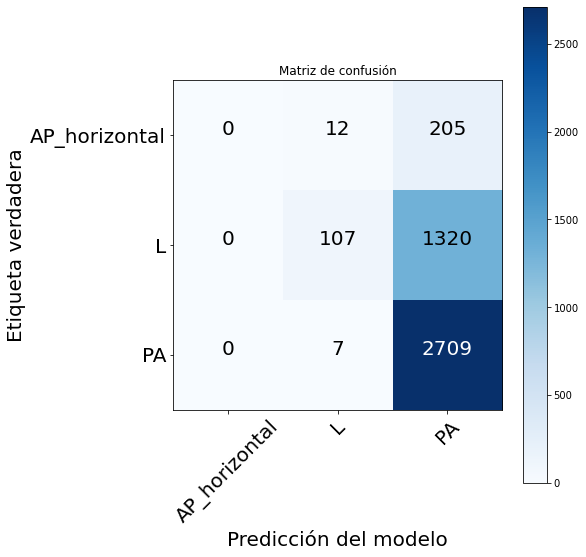

In [41]:
confusionMatrix = confusion_matrix(gts,preds_classes)

plot_confusion_matrix(confusionMatrix,test_batches.class_indices.keys())

En este caso, podemos ver que el modelo no aprendió, se limitó a clasificar a todas las imágenes como pertenecientes a una sola clase.

# Curvas AUC ROC y Precision Recall

In [42]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [43]:
y_test = pd.get_dummies(gts).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


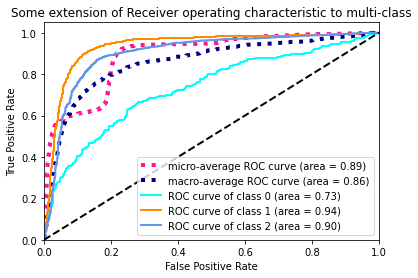

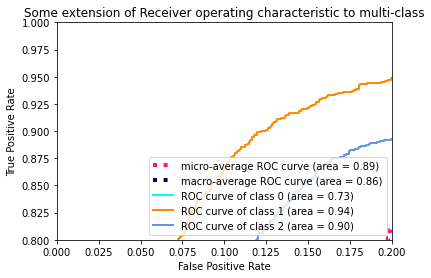

In [44]:
y_score = result_test
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [45]:
Y_test = pd.get_dummies(gts).to_numpy()
y_score = result_test

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])


# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.81


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.81')

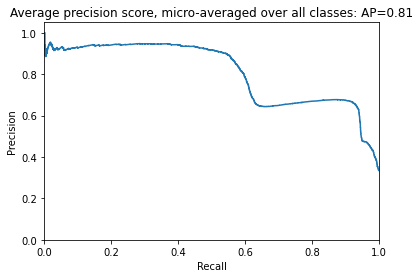

In [47]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

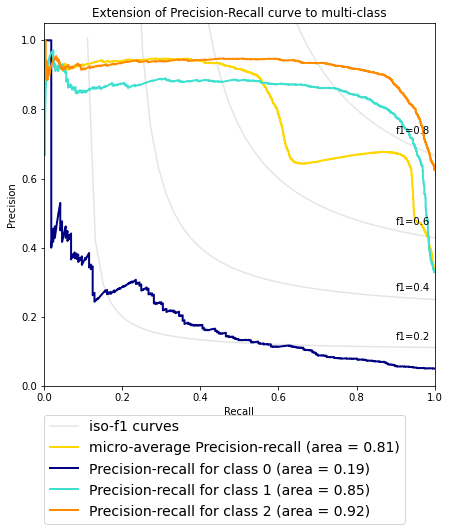

In [48]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(NUM_CLASSES), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()